# Learning‑Rate schedulers

PhyAGI includes a flexible `WarmupDecayCooldownLR` scheduler that lets you design learning‑rate curves composed of three distinct phases:

- **Warmup** – ramp the learning rate up from an initial value.
- **Decay** – gradually reduce the learning rate once training is stable.
- **Cooldown** *(optional)* – end training with a small, steady learning rate.

This modular design makes it easy to align the learning‑rate dynamics with your model architecture, dataset size, and optimiser.

In [1]:
import torch
import matplotlib.pyplot as plt

from phyagi.optimizers.schedulers.warmup_decay import WarmupDecayCooldownLR


def get_optimizer() -> torch.optim.Optimizer:
    model = torch.nn.Linear(2, 1)
    return torch.optim.SGD(model.parameters(), lr=0.1)


def plot_scheduler(optimizer: torch.optim.Optimizer, scheduler: WarmupDecayCooldownLR, total_num_steps: int = -1, title: str = "") -> None:
    lrs = []
    for _ in range(total_num_steps):
        optimizer.step()
        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])

    plt.plot(lrs)
    plt.xlabel("step")
    plt.ylabel("learning rate")
    plt.title(title)


## Warmup stage

During *warmup* the learning rate is smoothly increased from `warmup_init_lr` to `warmup_max_lr` over `warmup_steps` optimization steps.

| Parameter | Description |
|-----------|-------------|
| `warmup_init_lr` | Learning rate at step **0** |
| `warmup_max_lr`  | Learning rate at the end of warmup |
| `warmup_steps`   | Number of steps allocated to warmup |

**Tip**: A logarithmic warmup often works better for large transformer models, while a linear schedule is usually sufficient for smaller architectures.

The plots below compare *linear* and *logarithmic* warmup curves.

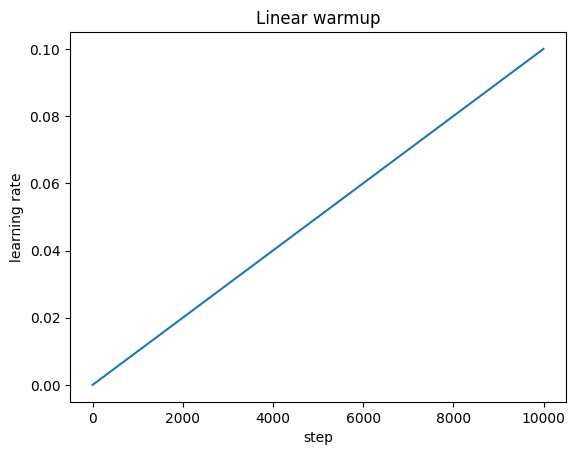

In [2]:
optimizer = get_optimizer()
total_num_steps = 10000

scheduler = WarmupDecayCooldownLR(optimizer, total_num_steps=total_num_steps, warmup_min_lr=0.0, warmup_max_lr=0.1, warmup_num_steps=10000, warmup_type="linear")
plot_scheduler(optimizer, scheduler, total_num_steps, title="Linear warmup")

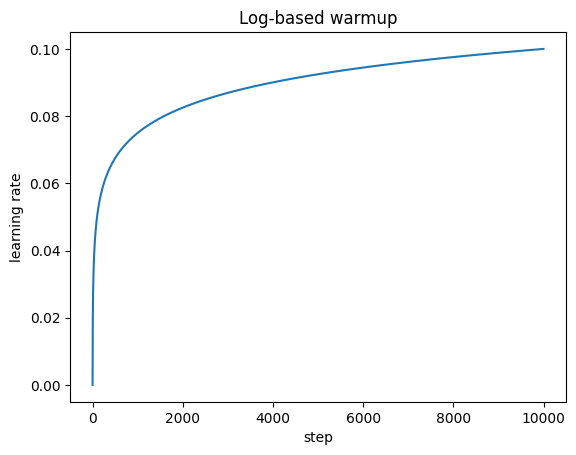

In [3]:
optimizer = get_optimizer()
total_num_steps = 10000

scheduler = WarmupDecayCooldownLR(optimizer, total_num_steps=total_num_steps, warmup_min_lr=0.0, warmup_max_lr=0.1, warmup_num_steps=10000, warmup_type="log")
plot_scheduler(optimizer, scheduler, total_num_steps, title="Log-based warmup")

## Decay stage

Once the model has reached its peak learning rate, the *decay* stage gradually reduces it from `warmup_max_lr` to `decay_min_lr`.

Two common decay strategies are supported:

1. **Cosine decay** – mimics cyclical annealing with a smooth cosine wave.
2. **Exponential decay** – halves (or otherwise scales) the learning rate every *k* steps.

The `decay_steps` parameter controls the length of this phase, after which the learning rate plateaus at `decay_min_lr`.


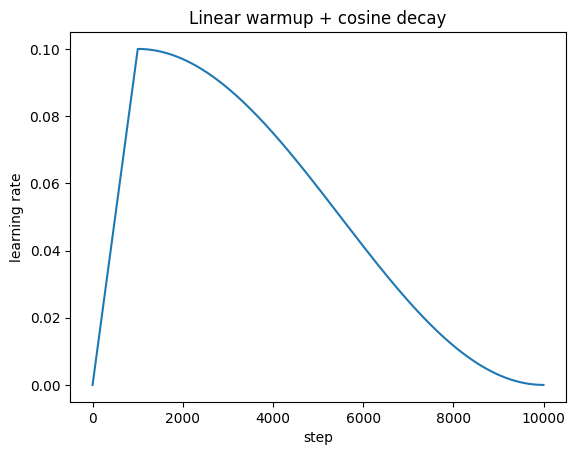

In [4]:
optimizer = get_optimizer()
total_num_steps = 10000

scheduler = WarmupDecayCooldownLR(optimizer, total_num_steps=total_num_steps, warmup_min_lr=0.0, warmup_max_lr=0.1, warmup_num_steps=1000, warmup_type="linear", decay_min_lr=0.0, decay_num_steps=9000, decay_type="cosine")
plot_scheduler(optimizer, scheduler, total_num_steps, title="Linear warmup + cosine decay")

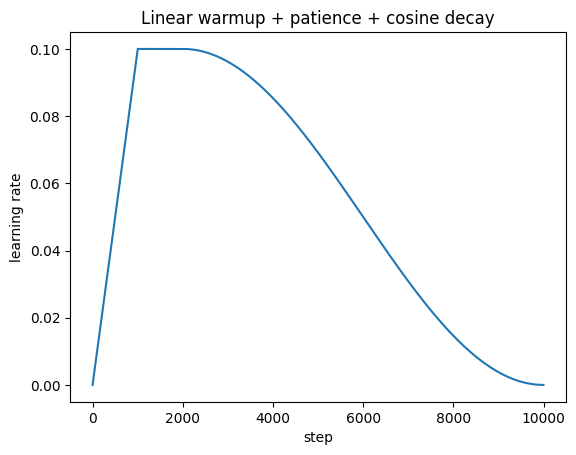

In [5]:
optimizer = get_optimizer()
total_num_steps = 10000

scheduler = WarmupDecayCooldownLR(optimizer, total_num_steps=total_num_steps, warmup_min_lr=0.0, warmup_max_lr=0.1, warmup_num_steps=1000, warmup_patience_num_steps=1000, warmup_type="linear", decay_min_lr=0.0, decay_num_steps=8000, decay_type="cosine")
plot_scheduler(optimizer, scheduler, total_num_steps, title="Linear warmup + patience + cosine decay")

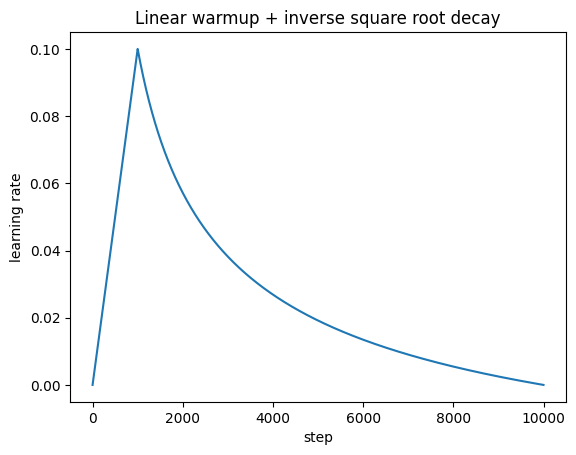

In [6]:
optimizer = get_optimizer()
total_num_steps = 10000

scheduler = WarmupDecayCooldownLR(optimizer, total_num_steps=total_num_steps, warmup_min_lr=0.0, warmup_max_lr=0.1, warmup_num_steps=1000, warmup_type="linear", decay_min_lr=0.0, decay_num_steps=9000, decay_type="inverse_square_root")
plot_scheduler(optimizer, scheduler, total_num_steps, title="Linear warmup + inverse square root decay")

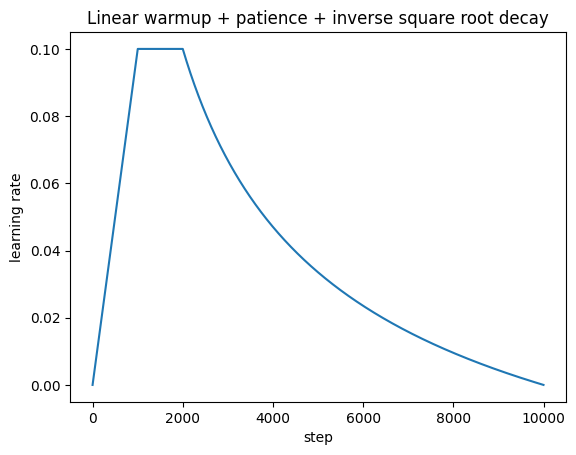

In [7]:
optimizer = get_optimizer()
total_num_steps = 10000

scheduler = WarmupDecayCooldownLR(optimizer, total_num_steps=total_num_steps, warmup_min_lr=0.0, warmup_max_lr=0.1, warmup_num_steps=1000, warmup_patience_num_steps=1000, warmup_type="linear", decay_min_lr=0.0, decay_num_steps=8000, decay_type="inverse_square_root")
plot_scheduler(optimizer, scheduler, total_num_steps, title="Linear warmup + patience + inverse square root decay")

## Cooldown stage

Some training runs benefit from a short *cooldown* during which the learning rate is held constant at `decay_min_lr` to stabilise the final updates.

Enable it by setting `cooldown_steps > 0`. If disabled, the schedule simply ends at the conclusion of the decay phase.

**Note**: Cooldown is particularly useful for Reinforcement Learning fine‑tuning or when using very small batch sizes.

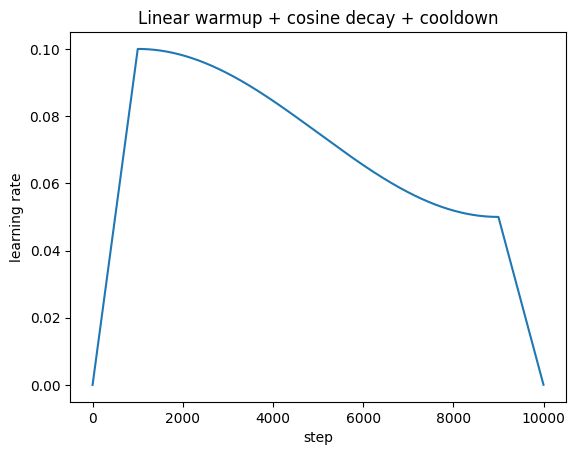

In [8]:
optimizer = get_optimizer()
total_num_steps = 10000

scheduler = WarmupDecayCooldownLR(optimizer, total_num_steps=total_num_steps, warmup_min_lr=0.0, warmup_max_lr=0.1, warmup_num_steps=1000, warmup_type="linear", decay_min_lr=0.05, decay_num_steps=8000, decay_type="cosine", cooldown_min_lr=0.0, cooldown_num_steps=1000)
plot_scheduler(optimizer, scheduler, total_num_steps, title="Linear warmup + cosine decay + cooldown")

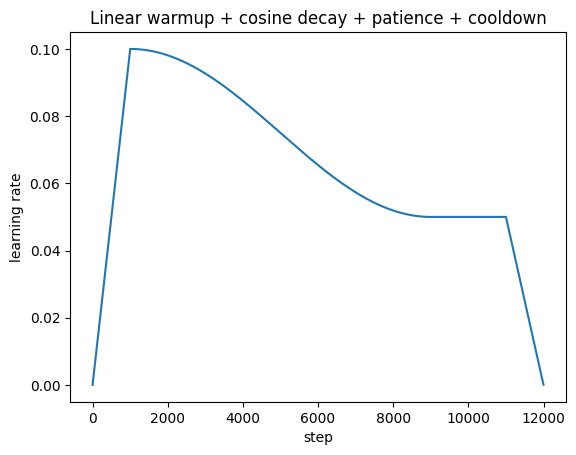

In [9]:
optimizer = get_optimizer()
total_num_steps = 12000

scheduler = WarmupDecayCooldownLR(optimizer, total_num_steps=total_num_steps, warmup_min_lr=0.0, warmup_max_lr=0.1, warmup_num_steps=1000, warmup_type="linear", decay_min_lr=0.05, decay_num_steps=8000, decay_patience_num_steps=2000, decay_type="cosine", cooldown_min_lr=0.0, cooldown_num_steps=1000)
plot_scheduler(optimizer, scheduler, total_num_steps, title="Linear warmup + cosine decay + patience + cooldown")

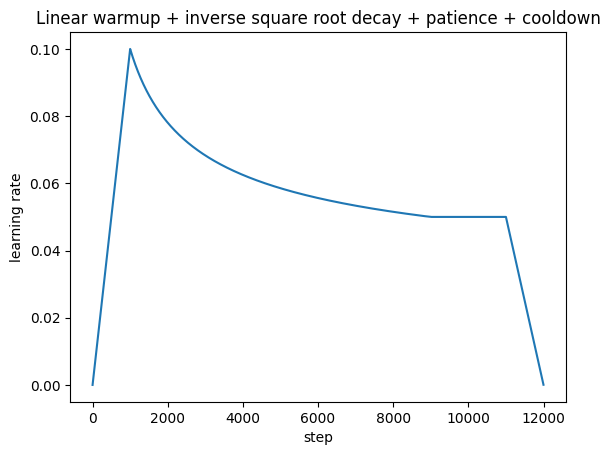

In [10]:
optimizer = get_optimizer()
total_num_steps = 12000

scheduler = WarmupDecayCooldownLR(optimizer, total_num_steps=total_num_steps, warmup_min_lr=0.0, warmup_max_lr=0.1, warmup_num_steps=1000, warmup_type="linear", decay_min_lr=0.05, decay_num_steps=8000, decay_patience_num_steps=2000, decay_type="inverse_square_root", cooldown_min_lr=0.0, cooldown_num_steps=1000)
plot_scheduler(optimizer, scheduler, total_num_steps, title="Linear warmup + inverse square root decay + patience + cooldown")

## Putting it all together

The example below shows how to compose all three phases into a single end‑to‑end schedule. By mixing and matching warmup shapes, decay strategies, and cooldown lengths you can cover most learning rate policies found in the literature.

```python
from phyagi.optimizers.schedulers.warmup_decay import WarmupDecayCooldownLR

scheduler = WarmupDecayCooldownLR(
    optimizer,
    warmup_init_lr=1e-6,
    warmup_max_lr=5e-4,
    warmup_steps=1000,
    decay_min_lr=5e-6,
    decay_steps=20000,
    cooldown_steps=1000,
    decay_strategy="cosine",
)
```

Feel free to experiment with the hyper‑parameters above to craft a schedule that best suits your task.


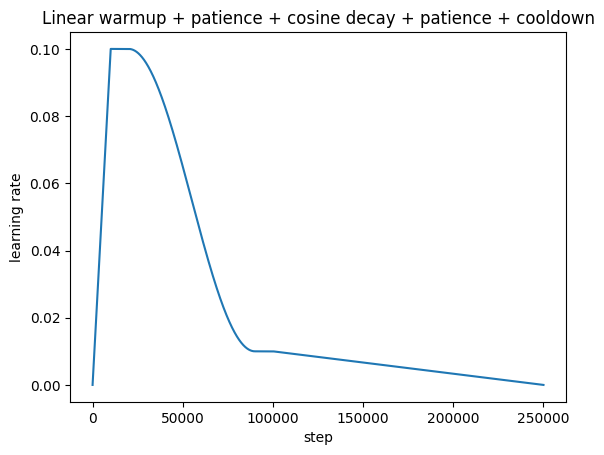

In [11]:
optimizer = get_optimizer()
total_num_steps = 250000

scheduler = WarmupDecayCooldownLR(optimizer, total_num_steps=total_num_steps, warmup_min_lr=0.0, warmup_max_lr=0.1, warmup_num_steps=10000, warmup_patience_num_steps=10000, warmup_type="linear", decay_min_lr=0.01, decay_num_steps=70000, decay_patience_num_steps=10000, decay_type="cosine", cooldown_min_lr=0.0, cooldown_num_steps=150000)
plot_scheduler(optimizer, scheduler, total_num_steps, title="Linear warmup + patience + cosine decay + patience + cooldown")